# Market States approach

- From the observations that with tabular models (gradient boosting ensemble),
shuffling the data guarantees no overfitting 
while splitting with chronological order overfits / does not capture the test probability distribution, 
it seems like a time-series approach is necessary :
timestamps are not independant draws of one underlying random variable.
- Defining some latent state of the time-series is expected to be an improvement,
- Also possible to cluster the timesteps into market modes, then to fit a predictor for each market mode.
- Market modes can be defined from the covariance matrix of the features
- Covariance matrix filtering techniques to reduce noise 

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
from typing import List
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

for dirname, _, filenames in os.walk("/kaggle/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

KAGGLE = False  # define paths accordingly
SUBMISSION = False  # use smaller datasets during dev

if KAGGLE:
    crypto_folder = Path("/kaggle/input/drw-crypto-market-prediction")
else:
    crypto_folder = Path("../raw_data/crypto")

## Helper functions

In [8]:
def get_clean_crypto_data(train: bool = True) -> pl.LazyFrame:
    """
    Load and clean crypto data, returning either train or test set.

    Args:
        train: If True, return training set. If False, return test set.

    Returns:
        Cleaned lazy frame with columns that have variance and no infinite values.
    """

    filename = "train.parquet" if train else "test.parquet"

    # load data
    crypto_lazy = pl.scan_parquet(crypto_folder / filename)
    n_cols = len(crypto_lazy.collect_schema().names())

    if train and KAGGLE:
        # rename timestamp column
        crypto_lazy = crypto_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Remove columns with zero variance in the training set
    train_lazy = pl.scan_parquet(crypto_folder / "train.parquet")
    if KAGGLE:
        train_lazy = train_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Get column names and calculate variance on training set (for consistency)
    crypto_var = train_lazy.select(pl.exclude(["timestamp"]).var())

    crypto_var_cols = (
        crypto_var.select(pl.all() == 0.0)
        .first()
        .collect()
        .to_pandas()
        .T.rename(columns={0: "is_variance_null"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("is_variance_null")["column_name"]
        .unique()
    )

    crypto_cols_with_var = crypto_var_cols[False]

    try:
        cols_no_var = crypto_var_cols[True]
        print(f"Columns with no variance : {cols_no_var}")
    except KeyError:
        print("All columns have variance in the train set")

    # remove columns that have no variance in the training set
    train_lazy = train_lazy.select(
        ["timestamp"] + [pl.col(c) for c in crypto_cols_with_var]
    )

    # Remove columns with infinite values (check on training set)
    current_columns = train_lazy.collect_schema().names()
    contains_infinite_cols = (
        train_lazy.select(pl.exclude("timestamp").abs().max().is_infinite())
        .collect()
        .to_pandas()
        .T.rename(columns={0: "contains_infinite"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("contains_infinite")["column_name"]
        .unique()
    )

    try:
        cols_with_inf_vals = contains_infinite_cols[True]
        print(f"Columns with infinite values : {cols_with_inf_vals}")
    except KeyError:
        print("No columns with infinite values")

    if not train:
        # add dummy timestamps
        crypto_lazy = crypto_lazy.with_columns(
            ID=range(1, crypto_lazy.select(pl.len()).collect().item() + 1)
        )
    # Filter clean columns based on what's available in the current dataset
    clean_columns = [
        c for c in current_columns if c in contains_infinite_cols[False]
    ] + ["timestamp", "ID"]
    available_columns = crypto_lazy.collect_schema().names()
    final_columns = [c for c in clean_columns if c in available_columns]
    print(f"Eventually {len(final_columns)}, removed {n_cols - len(final_columns)}")

    return crypto_lazy.select(final_columns)


def get_diff_features(df: pl.LazyFrame, stats_columns: List[str]):
    return (
        df.with_columns(pl.exclude(stats_columns).diff())
        .with_row_index()
        .fill_null(strategy="backward")
        .select(pl.exclude("index"))
    )


def get_ma_features(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_mean(window_size=23, min_samples=1))


def get_rolling_var(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_var(window_size=23, min_samples=1))

## Metadata

In [2]:
stats_columns = [
    "timestamp",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
stats_columns_test = [
    "ID",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
X_exclude = ["timestamp", "label"]
X_test_exclude = ["ID", "label"]

## Load data

In [ ]:
crypto_lazy_clean = get_clean_crypto_data(train=True)
crypto_lazy_clean.sink_parquet("crypto_lazy_clean.parquet")
# cols = crypto_lazy_clean.collect_schema().names()

Columns with no variance : ['X864' 'X867' 'X869' 'X870' 'X871' 'X872']
Columns with infinite values : ['X697' 'X698' 'X699' 'X700' 'X701' 'X702' 'X703' 'X704' 'X705' 'X706'
 'X707' 'X708' 'X709' 'X710' 'X711' 'X712' 'X713' 'X714' 'X715' 'X716'
 'X717']
Eventually 870, removed 27


In [3]:
crypto = pd.read_parquet("crypto_lazy_clean.parquet")
crypto.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X883,X884,X885,X886,X887,X888,X889,X890,label,timestamp
0,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539,2023-03-01 00:00:00
1,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686,2023-03-01 00:01:00
2,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505,2023-03-01 00:02:00
3,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703,2023-03-01 00:03:00
4,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452,2023-03-01 00:04:00


In [4]:
cols = crypto.columns

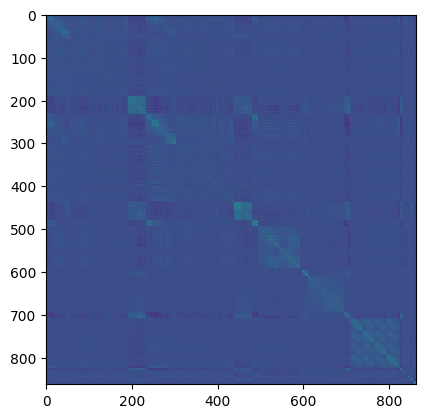

In [5]:
n_samples = 50_000
cov = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).cov()
from matplotlib import pyplot as plt

plt.imshow(cov)

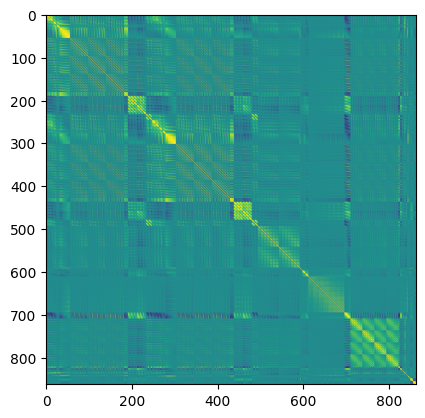

In [6]:
cor = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).corr()
plt.imshow(cor)

In [13]:
svd = np.linalg.svd(cov.values, hermitian=True)
U, S = svd.U, svd.S

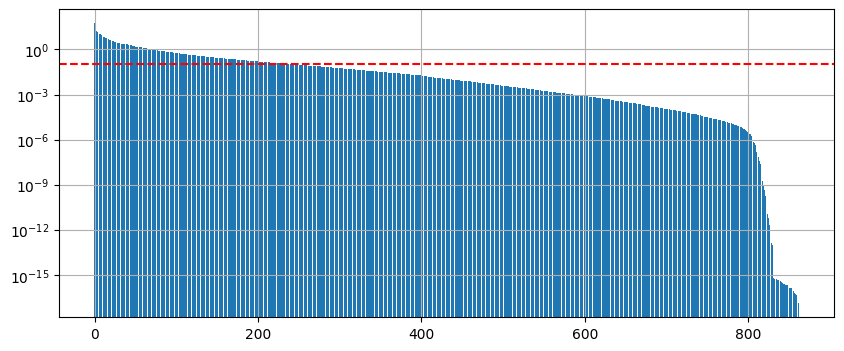

In [17]:
_, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(S)), S)
ax.set_yscale("log")
ax.axhline(0.1, c="red", linestyle="--")
ax.grid()

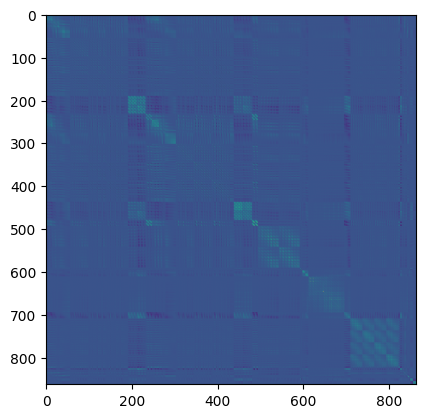

In [20]:
cov_clean = U @ np.diag(np.where(S > 1.0, S, np.zeros_like(S))) @ U.T

plt.imshow(cov_clean)

In [5]:
# join level with diff values
# crypto_lazy_clean = crypto_lazy_clean.join(
#     get_diff_features(crypto_lazy_clean, stats_columns),
#     on=stats_columns,
#     how="inner",
#     suffix="_diff",
# )

crypto_lazy_clean = crypto_lazy_clean.join(
    get_ma_features(crypto_lazy_clean, [c for c in cols if c not in stats_columns]),
    on=stats_columns,
    how="inner",
    suffix="_ma23",
)
# print(len(crypto_lazy_clean.collect_schema().names()))
# crypto_lazy_clean = crypto_lazy_clean.join(
#     get_rolling_var(
#         crypto_lazy_clean.select(cols),
#         [c for c in cols if c not in stats_columns]
#         ),
#     on=stats_columns,
#     how="inner",
#     suffix="_var23",
# )
print(len(crypto_lazy_clean.collect_schema().names()))

1733


In [6]:
X = crypto_lazy_clean.select(pl.exclude(X_exclude)).collect().to_numpy()
y = crypto_lazy_clean.select(pl.col("label")).collect().to_numpy().T[0]

if not SUBMISSION:
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=False,  # TODO : question this, whether timestamps are independant draws
        random_state=42,
    )
else:
    X_train, y_train = X, y
del X
del y

## Train model

In [ ]:
lr = 1.0

lin = RandomForestRegressor(
    # fit_intercept=True,
    n_estimators=80,
    n_jobs=-1,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features="sqrt",
    max_samples=0.5,
    random_state=41,
)
# n_samples = 80_000
lin.fit(
    X_train,
    y_train,
    # sample_weight=np.flip(1.0 / np.sqrt(np.arange(1, n_samples+1)))
)

y_train_lin = lin.predict(X_train)

print(f"R2 train lin: {r2_score(y_train, y_train_lin)}")
print(f"Pearson train lin : {pearsonr(y_train, y_train_lin)}")

y_train_res = y_train - lr * y_train_lin


lgb_model = lgb.LGBMRegressor(
    random_state=42,
    # weight=np.flip(1.0 / np.sqrt(np.arange(1, len(X_train)+1))),
    # n_estimators=80,
    # max_depth=10,
    n_jobs=-1,
)
lgb_model.fit(X_train, y_train_res)

y_train_hat = lgb_model.predict(X_train)

print(f"R2 train : {r2_score(y_train, y_train_hat + lr * y_train_lin)}")
print(f"Pearson train : {pearsonr(y_train, y_train_hat + lr * y_train_lin)}")

if not SUBMISSION:
    y_test_lin = lin.predict(X_test)

    print(f"R2 test lin : {r2_score(y_test, y_test_lin)}")
    print(f"Pearson test lin : {pearsonr(y_test, y_test_lin)}")

    y_test_hat = lgb_model.predict(X_test)

    print(f"R2 test : {r2_score(y_test, y_test_hat + lr * y_test_lin)}")
    print(f"Pearson test : {pearsonr(y_test, y_test_hat + lr * y_test_lin)}")

R2 train lin: 0.238548149850638
Pearson train lin : PearsonRResult(statistic=np.float64(0.5740368195932376), pvalue=np.float64(0.0))


## Load test data

In [ ]:
crypto_lazy_test = get_clean_crypto_data(train=False)

# create unique row identifier
n = crypto_lazy_test.select(pl.len()).collect().item()
crypto_lazy_test = crypto_lazy_test.with_columns(ID=range(1, n + 1))

print(crypto_lazy_test.select(pl.len()).collect().item())

crypto_lazy_test = crypto_lazy_test.join(
    get_diff_features(crypto_lazy_test, stats_columns_test),
    on=stats_columns_test,
    how="inner",
    suffix="_diff",
)

# crypto_lazy_test = get_diff_features(crypto_lazy_test, stats_columns_test)
assert n == crypto_lazy_test.select(pl.len()).collect().item()

Columns with no variance : ['X864' 'X867' 'X869' 'X870' 'X871' 'X872']
Columns with infinite values : ['X697' 'X698' 'X699' 'X700' 'X701' 'X702' 'X703' 'X704' 'X705' 'X706'
 'X707' 'X708' 'X709' 'X710' 'X711' 'X712' 'X713' 'X714' 'X715' 'X716'
 'X717']
Eventually 870, removed 26
538150


## Predict target \& submit

In [ ]:
X_test = crypto_lazy_test.select(pl.exclude(X_test_exclude)).collect().to_numpy()
y_lin_test = lin.predict(X_test)
y_hat_lgb_test = lgb_model.predict(X_test)

del X_test

In [ ]:
crypto_lazy_test = crypto_lazy_test.with_columns(
    ID=range(1, n + 1), prediction=y_hat_lgb_test + lr * y_lin_test
)
crypto_lazy_test.head(5).collect()
crypto_lazy_test.select([pl.col("ID"), pl.col("prediction")]).collect().write_csv(
    Path("submission.csv")
)